In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets
from dbc.main import KmeansDiscreteMinmaxClassifier, CmeansDiscreteBayesianClassifier
from dbc.utils import compute_class_conditional_risk_with_labels, compute_prior_best,compute_global_risk
from sklearn.model_selection import train_test_split

In [27]:
X, y = datasets.make_blobs(
        n_samples= [125 * 5 , 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True,
)

T = 25
fuzzifier = 2

DMC = KmeansDiscreteMinmaxClassifier(n_clusters=T)
DMC.fit(X, y)

SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
# SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier)
SPDBC.fit(X, y)

y_pred_DMC = DMC.predict(X)
risks_DMC = compute_class_conditional_risk_with_labels(y, y_pred_DMC)[0]

pi_star_SPDBC, risk_history = compute_prior_best(X, y, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, SPDBC.prior, alpha=1, n_iter=300, eps=1e-3, return_history=True)

y_pred_SPDBC = SPDBC.predict(X, prior_pred=pi_star_SPDBC)
risks_SPDBC = compute_class_conditional_risk_with_labels(y, y_pred_SPDBC)[0]

print("DMC empirical class conditional risk:\n", risks_DMC, "\n")
print("SPDEC empirical class conditional risk:\n", risks_SPDBC, "\n")
# plt.plot(risk_history)

DMC empirical class conditional risk:
 [0.1936 0.176 ] 

SPDEC empirical class conditional risk:
 [0.168 0.168] 



Text(0.5, 1.0, 'SPDEC')

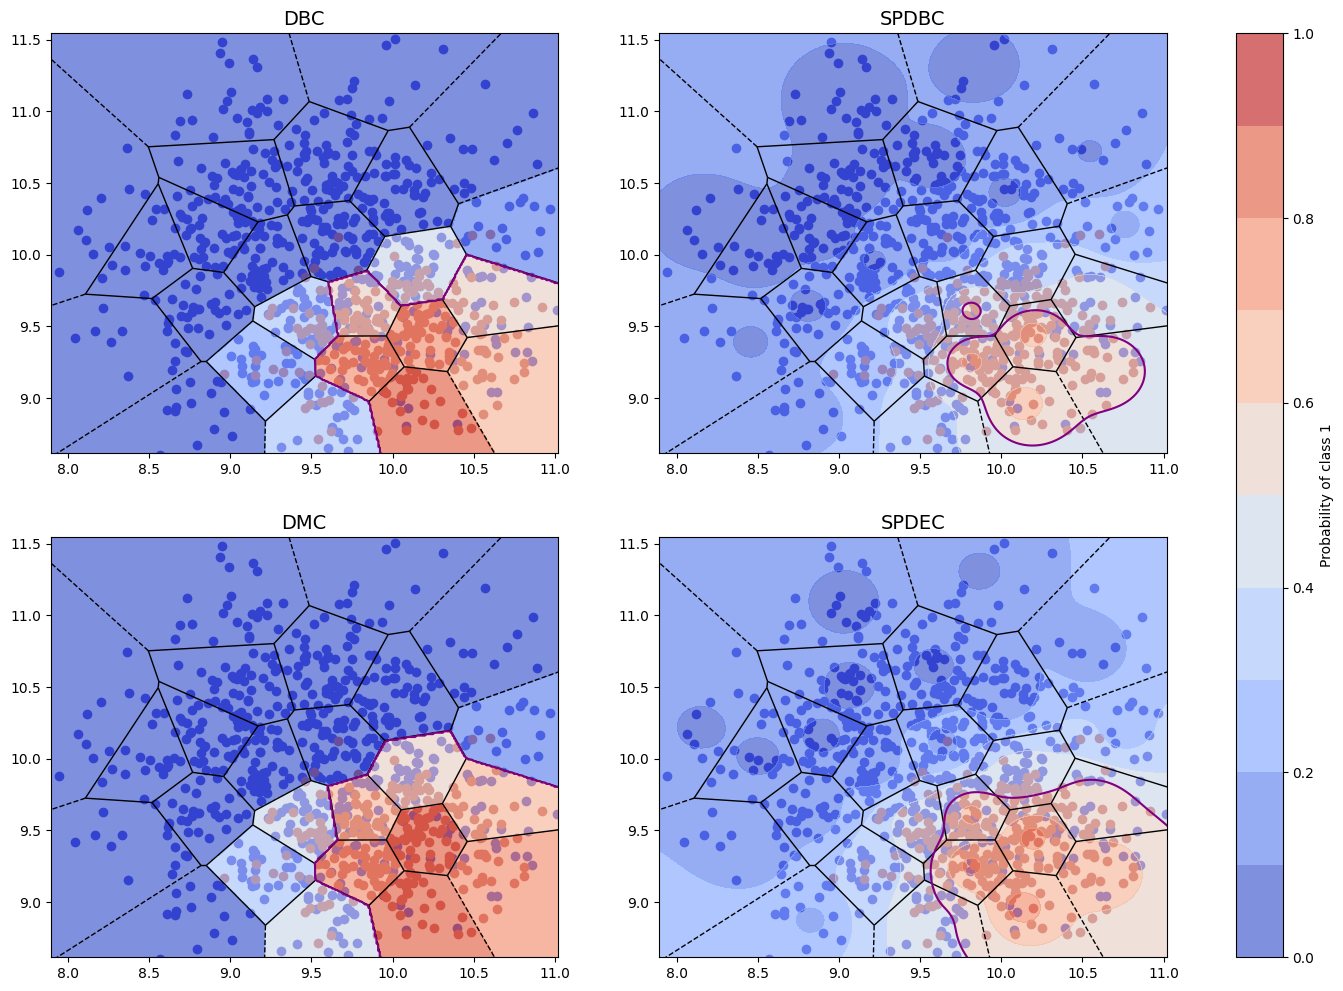

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DMC.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0,0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0,1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1,0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1,1])

Z0 = DMC.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=DMC.prior)
Z1 = DMC.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=DMC.prior_best)
Z2 = SPDBC.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=SPDBC.prior)
Z3 = SPDBC.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=pi_star_SPDBC)

Z0 = Z0[:, 1].reshape(xx.shape)
Z1 = Z1[:, 1].reshape(xx.shape)
Z2 = Z2[:, 1].reshape(xx.shape)
Z3 = Z3[:, 1].reshape(xx.shape)

class0_indices = (y == 0)
class1_indices = (y == 1)
for idx, (i, j) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    ax[i, j].scatter(X[class0_indices, 0], X[class0_indices, 1], color='mediumblue')
    ax[i, j].scatter(X[class1_indices, 0], X[class1_indices, 1], color='firebrick')

contour0 = ax[0,0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1,0].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[0,1].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour3 = ax[1,1].contourf(xx, yy, Z3, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5

boundary0 = ax[0,0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1,0].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[0,1].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[1,1].contour(xx, yy, Z3, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')
#
ax[0,0].set_title('DBC', fontsize=14)
ax[1,0].set_title('DMC', fontsize=14)
ax[0,1].set_title('SPDBC', fontsize=14)
ax[1,1].set_title('SPDEC', fontsize=14)

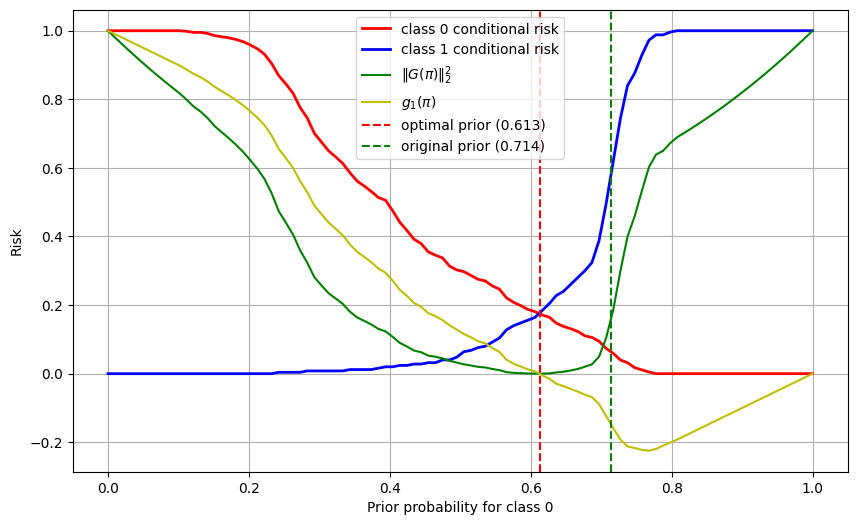

In [4]:
prior_values = np.linspace(0, 1, 100)  # 生成0到1之间的100个值
prior_pred = np.zeros((100, 2))
prior_pred[:, 0] = prior_values
prior_pred[:, 1] = 1 - prior_values  # 确保每行和为1

# 计算不同prior下的风险
risks = np.zeros((100, 2))
for i in range(100):
    y_pred = SPDBC.predict(X, prior_pred=prior_pred[i, :].reshape(1, -1))
    # y_pred = DMC.predict(X, prior_pred=prior_pred[i, :].reshape(1, -1))
    risk = compute_class_conditional_risk_with_labels(y, y_pred)
    risks[i,:] = risk[0]

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(prior_values, risks[:,0], 'r-', linewidth=2, label = 'class 0 conditional risk')
plt.plot(prior_values, risks[:,1], 'b-', linewidth=2, label = 'class 1 conditional risk')
r = prior_pred[:, 1]*risks[:,1]+prior_pred[:, 0]*risks[:,0]

# plt.plot(prior_values, r, 'g-', linewidth=2, label = '$\hat{r}$ : Empirical Bayesian risk')
plt.plot(prior_values, (risks[:,1] - r)**2 + (risks[:,0] - r)**2, 'g-', label = '$\| G(\pi) \|_2^2$')
plt.plot(prior_values, (risks[:,0] - r), 'y-', label = '$g_1(\pi)$')
# plt.plot(prior_values, abs(risks[:,1] - r) + abs(risks[:,0] - r), 'g-', label='$\sum_k (|\hat{R}_k-\hat{r}|)$')
plt.xlabel('Prior probability for class 0')
plt.ylabel('Risk')
# plt.title('Bayes Risk vs Prior Probability')
plt.grid(True)
# plt.axvline(x=DMC.prior_star[0, 0], color='r', linestyle='--',
#             label=f'DMC optimal prior ({DMC.prior_star[0, 0]:.3f})')
plt.axvline(x=pi_star_SPDBC[0], color='r', linestyle='--',
            label=f'optimal prior ({pi_star_SPDBC[0]:.3f})')


plt.axvline(x=SPDBC.prior[0], color='g', linestyle='--',
            label=f'original prior ({SPDBC.prior[0]:.3f})')
plt.legend()
plt.show()


In [22]:
T = 8
fuzzifier = 2

num=100
risks_DMC = np.zeros([num, 2])
risks_SPDBC = np.zeros([num, 2])

# 重复100次
for i in range(num):
    # Generate data
    X, y = datasets.make_blobs(
        n_samples= [125 * 5 , 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True,
    )

    # 分割数据集，test_size=0.2表示测试集占20%
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,  # 测试集比例
        random_state=43,  # 随机种子，确保结果可重现
        stratify=y  # 保持分割后各类别的比例与原始数据集一致
    )

    # 添加噪音
    X_train_noise = X_train + np.random.normal(0, 0, size=X_train.shape)
    X_test_noise = X_test + np.random.normal(0, 0, size=X_test.shape)

    DMC = KmeansDiscreteMinmaxClassifier(n_clusters=T)
    DMC.fit(X_train_noise, y_train)

    SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
    SPDBC.fit(X_train_noise, y_train)

    # DMC预测和风险计算
    y_pred_DMC = DMC.predict(X_test_noise)
    risks_DMC[i, :] = compute_class_conditional_risk_with_labels(y_test, y_pred_DMC)[0]

    pi_star_SPDBC = compute_prior_best(X_train, y_train, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, SPDBC.prior)

    y_pred_SPDBC = SPDBC.predict(X_test_noise, prior_pred=pi_star_SPDBC)
    risks_SPDBC[i, :] = compute_class_conditional_risk_with_labels(y_test, y_pred_SPDBC)[0]



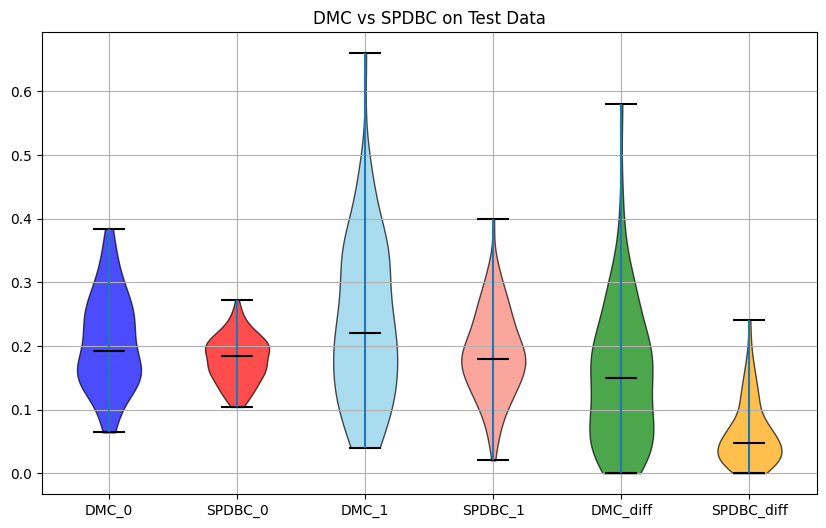

In [24]:
# 创建图形
plt.figure(figsize=(10, 6))

# 绘制小提琴图
violin_parts = plt.violinplot([risks_DMC[:, 0], risks_SPDBC[:, 0],
                               risks_DMC[:, 1], risks_SPDBC[:, 1],
                               abs(risks_DMC[:, 1] - risks_DMC[:, 0]),
                               abs(risks_SPDBC[:, 0] - risks_SPDBC[:, 1])],
                              showmedians=True)

# 自定义颜色和样式
colors = ['blue', 'red', 'skyblue', 'salmon', 'green', 'orange']
for i, body in enumerate(violin_parts['bodies']):
    body.set_facecolor(colors[i])
    body.set_alpha(0.7)
    body.set_edgecolor('black')

# 设置其他元素的样式
plt.setp(violin_parts['cmedians'], color='black')  # 均值标记
plt.setp(violin_parts['cmaxes'], color='black')  # 最大值线
plt.setp(violin_parts['cmins'], color='black')  # 最小值线

# 设置标签和标题
plt.xticks([1, 2, 3, 4, 5, 6],
           ['DMC_0', 'SPDBC_0', 'DMC_1', 'SPDBC_1', 'DMC_diff', 'SPDBC_diff'])
plt.title('DMC vs SPDBC on Test Data')
plt.grid(True)

plt.show()


In [10]:
T = 15
fuzzifier = 2

num=100
risks_DMC = np.zeros([num, 2])
risks_SPDBC = np.zeros([num, 2])

# 重复100次
for i in range(num):
    # Generate data
    X, y = datasets.make_blobs(
        n_samples= [125 * 5 , 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True,
    )

    DMC = KmeansDiscreteMinmaxClassifier(n_clusters=T)
    DMC.fit(X, y)

    SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
    SPDBC.fit(X, y)

    # DMC预测和风险计算
    y_pred_DMC = DMC.predict(X)
    risks_DMC[i, :] = compute_class_conditional_risk_with_labels(y, y_pred_DMC)[0]

    pi_star_SPDBC = compute_prior_best(X, y, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, SPDBC.prior)

    y_pred_SPDBC = SPDBC.predict(X, prior_pred=pi_star_SPDBC)
    risks_SPDBC[i, :] = compute_class_conditional_risk_with_labels(y, y_pred_SPDBC)[0]



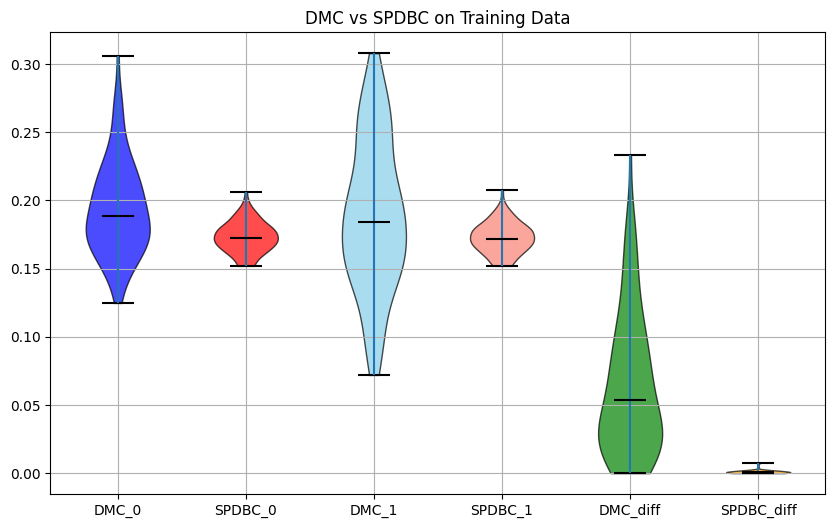

In [14]:
# 创建图形
plt.figure(figsize=(10, 6))

# 绘制小提琴图
violin_parts = plt.violinplot([risks_DMC[:, 0], risks_SPDBC[:, 0],
                               risks_DMC[:, 1], risks_SPDBC[:, 1],
                               abs(risks_DMC[:, 1] - risks_DMC[:, 0]),
                               abs(risks_SPDBC[:, 0] - risks_SPDBC[:, 1])],
                              showmedians=True)

# 自定义颜色和样式
colors = ['blue', 'red', 'skyblue', 'salmon', 'green', 'orange']
for i, body in enumerate(violin_parts['bodies']):
    body.set_facecolor(colors[i])
    body.set_alpha(0.7)
    body.set_edgecolor('black')

# 设置其他元素的样式
plt.setp(violin_parts['cmedians'], color='black')  # 均值标记
plt.setp(violin_parts['cmaxes'], color='black')  # 最大值线
plt.setp(violin_parts['cmins'], color='black')  # 最小值线

# 设置标签和标题
plt.xticks([1, 2, 3, 4, 5, 6],
           ['DMC_0', 'SPDBC_0', 'DMC_1', 'SPDBC_1', 'DMC_diff', 'SPDBC_diff'])
plt.title('DMC vs SPDBC on Training Data')
plt.grid(True)
plt.show()


In [80]:
T = 15
fuzzifier = 2.3

num=100
risks_DMC = np.zeros([num, 2])
risks_SPDBC = np.zeros([num, 2])

# 重复100次
for i in range(num):
    # Generate data
    X, y = datasets.make_blobs(
        n_samples= [125 * 5 , 125 * 2],
        n_features=2,
        centers=[(9.5, 10), (10, 9.4)],
        cluster_std=[[0.6, 0.6], [0.35, 0.3]],
        shuffle=True,
    )

    # 分割数据集，test_size=0.2表示测试集占20%
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,  # 测试集比例
        random_state=43,  # 随机种子，确保结果可重现
        stratify=y  # 保持分割后各类别的比例与原始数据集一致
    )

    # 添加噪音
    X_train_noise = X_train + np.random.normal(0, 0, size=X_train.shape)
    X_test_noise = X_test + np.random.normal(0, 0.3, size=X_test.shape)

    DMC = KmeansDiscreteMinmaxClassifier(n_clusters=T)
    DMC.fit(X_train_noise, y_train)

    SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
    SPDBC.fit(X_train_noise, y_train)

    # DMC预测和风险计算
    y_pred_DMC = DMC.predict(X_test_noise)
    risks_DMC[i, :] = compute_class_conditional_risk_with_labels(y_test, y_pred_DMC)[0]

    pi_star_SPDBC = compute_prior_best(X_train, y_train, SPDBC.loss_function, SPDBC.p_hat, SPDBC.membership_degree, SPDBC.prior)

    y_pred_SPDBC = SPDBC.predict(X_test_noise, prior_pred=pi_star_SPDBC)
    risks_SPDBC[i, :] = compute_class_conditional_risk_with_labels(y_test, y_pred_SPDBC)[0]



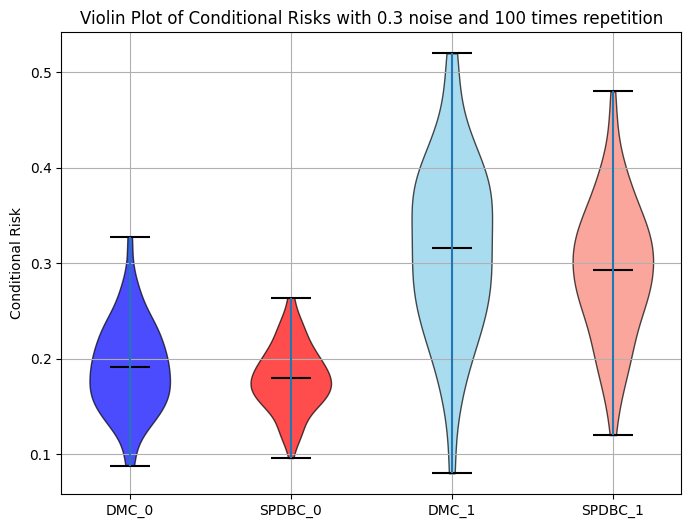

In [81]:
# 创建图形
plt.figure(figsize=(8, 6))

# 绘制小提琴图
violin_parts = plt.violinplot([risks_DMC[:, 0], risks_SPDBC[:, 0],
                               risks_DMC[:, 1], risks_SPDBC[:, 1]],
                              showmeans=True)

# 自定义颜色和样式
colors = ['blue', 'red', 'skyblue', 'salmon']
for i, body in enumerate(violin_parts['bodies']):
    body.set_facecolor(colors[i])
    body.set_alpha(0.7)
    body.set_edgecolor('black')

# 设置其他元素的样式
plt.setp(violin_parts['cmeans'], color='black')  # 均值标记
plt.setp(violin_parts['cmaxes'], color='black')  # 最大值线
plt.setp(violin_parts['cmins'], color='black')  # 最小值线


# 设置标签和标题
plt.xticks([1, 2, 3, 4], ['DMC_0', 'SPDBC_0', 'DMC_1', 'SPDBC_1'])
plt.ylabel('Conditional Risk')
plt.title('Violin Plot of Conditional Risks with 0.3 noise and 100 times repetition')
plt.grid(True)

plt.show()
